# Classification of IMDB data from model hiddenstates and their sparse encodings

I'm interested in finding out if the sparse autoencoded representations are better for classification.


In [27]:
import os
import sys

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import hf_hub_download
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity

# Parameters

In [2]:
# define directories
model_name = "pythia-410m-deduped" # tested for pythia-70m-deduped and pythia-410m-deduped
model_path = f"EleutherAI/{model_name}"

# to push the model towards classifying the review
format_prompt='Consider if following review is positive or negative:\n"{scenario}"\nThe review is '
batch_size = 128
# I only look at hidden states of the last token position as this should have the prediction encoded
token_pos = -1 

## Load Model

In [3]:
# load model
model = AutoModelForCausalLM.from_pretrained(model_path).to(device='cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

# select left padding do the last token actually has relevant information
tokenizer.padding_side = 'left' 
layer_ids = np.arange(0, model.config.num_hidden_layers)

# Load data set
I do make the classification task relatively easy by selecting only short reviews.

In [4]:
def prep_dataset(dataset, format_prompt, min_len=250, max_len=500):
    
    # only select short reviews and format them
    dataset = dataset.filter(
        lambda x: len(x['text']) > min_len
    ).filter(
        lambda x: len(x['text']) < max_len
    ).map(
        lambda x: {'text': format_prompt.format(scenario=x['text']), 'label': x['label']},
    )
    
    # make sure there are the same numbers of positive and negative reviews
    num_samples = min(len(dataset.filter(lambda x: x['label'] == 0)), len(dataset.filter(lambda x: x['label'] == 1)))
    dataset_zero = dataset.filter(lambda x: x['label'] == 0).select(range(num_samples))
    dataset_one = dataset.filter(lambda x: x['label'] == 1).select(range(num_samples))

    dataset = concatenate_datasets([dataset_zero, dataset_one])
    # mix up the dataset
    dataset = dataset.shuffle()
    
    return dataset
    

In [26]:
train_set = prep_dataset(load_dataset("imdb", split="train"), format_prompt)
print(f"Training data samples: {len(train_set)}")
test_set = prep_dataset(load_dataset("imdb", split="test"), format_prompt)
print(f"Test data samples: {len(test_set)}")

Training data samples: 1802
Test data samples: 1966


## Get hidden activations
We get the outputs of the residual stream (the decoder block) per default.

In [28]:
def batchify(lst, batch_size):
    """Yield successive batch_size chunks from lst."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

def calc_hidden_states(model, dataset, batch_size=128, token_pos=-1):
    with torch.no_grad():
        dl = DataLoader(dataset["text"], batch_size=batch_size)
        hidden_states = torch.zeros((model.config.num_hidden_layers, len(dataset), model.config.hidden_size), device=model.device)
        labels = []
        for i, batch in enumerate(tqdm(dl)):
            tokenized_batch = tokenizer(batch, padding=True, return_tensors="pt").to(model.device)
            
            hidden_states_batch = model(**tokenized_batch, output_hidden_states=True)["hidden_states"]
            hidden_states_batch = torch.stack(hidden_states_batch)
            hidden_states_batch = hidden_states_batch[1:, :, token_pos, :] # ignore layer 0 (embedding layer)
            
            this_batch_size = hidden_states_batch.shape[1]
            start = i*batch_size
            end = start + this_batch_size
            hidden_states[:, start:end,:] = hidden_states_batch
    return hidden_states

In [29]:
hidden_states_train = calc_hidden_states(model, train_set, batch_size=batch_size, token_pos=token_pos)
hidden_states_test = calc_hidden_states(model, test_set, batch_size=batch_size, token_pos=token_pos)

100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


In [8]:
# make numpy arrays
hidden_states_train = hidden_states_train.cpu().numpy()
hidden_states_test = hidden_states_test.cpu().numpy()

In [9]:
# normalizing data
def get_scalers(hidden_states_train, layer_ids):
    scalers = {}
    for layer in layer_ids:
        scaler = StandardScaler()
        scaler.fit(hidden_states_train[layer])
        scalers[layer] = scaler
    return scalers
        
scalers = get_scalers(hidden_states_train, layer_ids)

# Classifying the hidden states

In [10]:
# Logistic regression
def logistic_regression(hidden_states_train, hidden_states_test, train_labels, test_labels, scalers):
    test_accs = {}
    for layer in scalers.keys():
        scaler = scalers[layer]
        lr = LogisticRegression(solver='liblinear', C=1e-2, random_state=0, max_iter=50).fit(scaler.transform(hidden_states_train[layer]), train_labels)
        test_accs[layer] = lr.score(scaler.transform(hidden_states_test[layer]), test_labels)
    return test_accs

test_accs = logistic_regression(hidden_states_train, hidden_states_test, train_set["label"], test_set["label"], scalers)

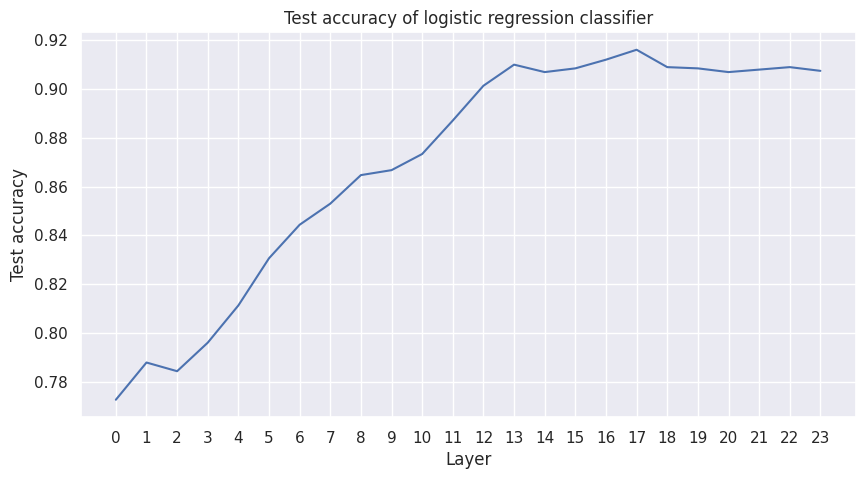

In [11]:
sns.set_theme()
plt.figure(figsize=(10, 5))
# plot values over keys    
plt.plot(list(test_accs.keys()), list(test_accs.values()))    
plt.xlabel("Layer")
plt.ylabel("Test accuracy")
plt.title("Test accuracy of logistic regression classifier")
plt.xticks(ticks=list(test_accs.keys()))  # Set x-ticks to only where you have keys
plt.show()


# Getting the sparse representations

You will have to clone the sparse coding repository to access the relevant class definitions.

```
git clone https://github.com/loganriggs/sparse_coding.git
```

You also need to add the folder to your path.

In [12]:
# add directory to path
import sys
sys.path.append(f'{os.path.abspath(os.path.join(os.getcwd(), os.pardir))}/sparse_coding')

In [13]:
# lets make the hidden_states torch tensors again
hidden_states_train = torch.from_numpy(hidden_states_train).to(model.device)
hidden_states_test = torch.from_numpy(hidden_states_test).to(model.device)

# Load the pretrained autoencoders

In [18]:
# it seems like not all autoencoders for all layers are available, so I just selected what seems to have been trained
if model_name == 'pythia-70m-deduped':
    layer_ids = np.arange(1, 4)
    ending = "_r6"
elif model_name == 'pythia-410m-deduped':
    layer_ids = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23]
    ending = "_r4"
    
autoencoders = {}
for layer in layer_ids:
    ae_download_location = hf_hub_download(repo_id=f"Elriggs/{model_name}", filename=f"tied_residual_l{layer}{ending}/_63/learned_dicts.pt")
    all_autoencoders = torch.load(ae_download_location)
    auto_num = 5
    autoencoder, hyperparams = all_autoencoders[auto_num]
    autoencoder.to_device(model.device)

    autoencoders[layer] = autoencoder

# Check reconstruction error

I found the reconstrution errors to be pretty high, but I checked with Logan (one of the authors of the sparse coding rep) and he said it matched their results.

In [19]:
def decode(autoencoder, encoded_hidden_states): 

    decoded_hidden_states = None
    for batch in batchify(encoded_hidden_states, batch_size=128):
        decoded_hidden_state_batch = autoencoder.decode(batch)
        if decoded_hidden_states is None:
            decoded_hidden_states = decoded_hidden_state_batch
        else:
            decoded_hidden_states = torch.concatenate((decoded_hidden_states, decoded_hidden_state_batch), axis=0)

    return decoded_hidden_states

def encode(autoencoder, hidden_states):
    # encode hidden states
    encoded_hidden_states = None
    for batch in batchify(hidden_states, batch_size=128):
        encoded_hidden_state_batch = autoencoder.encode(batch)
        if encoded_hidden_states is None:
            encoded_hidden_states = encoded_hidden_state_batch
        else:
            encoded_hidden_states = torch.concatenate((encoded_hidden_states, encoded_hidden_state_batch), axis=0)

    return encoded_hidden_states


In [20]:
hidden_states_train_encoded = {}
hidden_states_test_encoded = {}

for layer in tqdm(layer_ids):

    hidden_states_train_encoded[layer] = encode(autoencoders[layer], hidden_states_train[layer])
    hidden_states_test_encoded[layer] = encode(autoencoders[layer], hidden_states_test[layer])

hidden_states_train_decoded = {}
hidden_states_test_decoded = {}

for layer in layer_ids:

    hidden_states_train_decoded[layer] = decode(autoencoders[layer], hidden_states_train_encoded[layer])
    hidden_states_test_decoded[layer] = decode(autoencoders[layer], hidden_states_test_encoded[layer])


mse_errors = {}
cosine_similarities = {}

# print reconstruction error
for layer in layer_ids:
    mse_errors[layer] = round(torch.mean((hidden_states_train[layer] - hidden_states_train_decoded[layer])**2).item(), 4)
    cosine_similarities[layer] = round(torch.mean(cosine_similarity(hidden_states_train[layer], hidden_states_train_decoded[layer])).item(), 4)
print("Reconstruction errors:")
print("\nMSE:")
print(mse_errors)
print("\nCosine similarities:")
print(cosine_similarities)

100%|██████████| 12/12 [00:00<00:00, 141.11it/s]

Reconstruction errors:

MSE:
{2: 0.0495, 4: 0.1052, 6: 0.1255, 8: 0.1452, 10: 0.1528, 12: 0.1179, 14: 0.121, 16: 0.111, 18: 0.1367, 20: 0.1793, 22: 0.2675, 23: 14.6385}

Cosine similarities:
{2: 0.8896, 4: 0.8728, 6: 0.8517, 8: 0.8268, 10: 0.8036, 12: 0.8471, 14: 0.8587, 16: 0.923, 18: 0.9445, 20: 0.9457, 22: 0.9071, 23: 0.8633}


# Classification with sparse representations

In [21]:
# make numpy arrays
for layer in layer_ids:
    hidden_states_train_encoded[layer] = hidden_states_train_encoded[layer].cpu().numpy()
    hidden_states_test_encoded[layer] = hidden_states_test_encoded[layer].cpu().numpy()

In [22]:
# get scalers
scalers_encoded = get_scalers(hidden_states_train_encoded, layer_ids)
# classify
test_accs_encoded = logistic_regression(hidden_states_train_encoded, hidden_states_test_encoded, train_set["label"], test_set["label"], scalers_encoded)

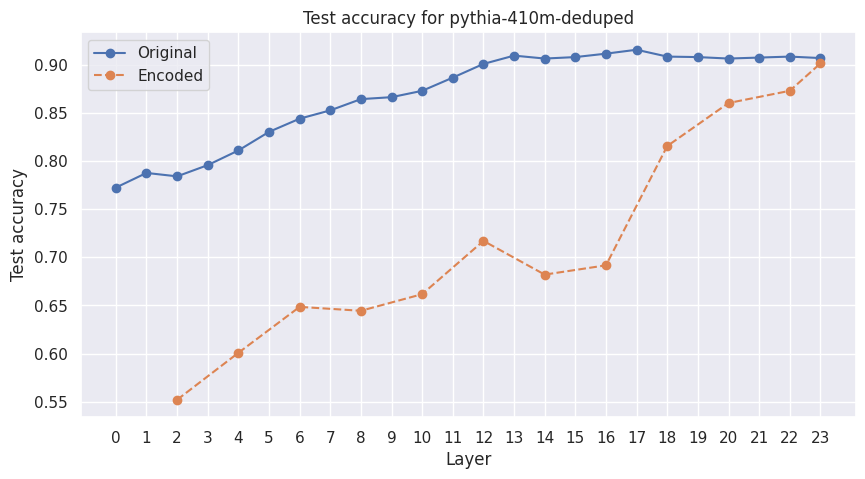

In [23]:
# plot both, the original and the encoded accuracies
sns.set_theme()
plt.figure(figsize=(10, 5))
# plot values over keys    
plt.plot(list(test_accs.keys()), list(test_accs.values()), label="Original", marker='o')    
plt.plot(list(test_accs_encoded.keys()), list(test_accs_encoded.values()), label="Encoded", linestyle='dashed', marker='o')    
plt.xlabel("Layer")
plt.ylabel("Test accuracy")
plt.title(f"Test accuracy for {model_name}")
plt.xticks(ticks=list(test_accs.keys()))  # Set x-ticks to only where you have keys
plt.legend()
plt.savefig(f"{model_name}_accs.png")
plt.show()